![logo](./graphics/OB-Logo.jpg)

In [1]:
# Created on 2025-04-06 by Brainvivo
# License: Apache License 2.0 with Commons Clause

# Open-Brain examples

Open-Brain is trained on functional MRI data to predict the neural activation patterns that images elicit across 1,024 distinct brain regions. These predicted responses serve as image embeddings, sensitively encoding the emotional reactions each image evokes within a specific cohort. For more information please refer to the [project page](https://brainvivodev.github.io/openbrain-brainvivo/).

The tool predicts the brain response from from ImageBind (Girdhar et al.) or OpenCLIP (Ilharco, et al., 2021) image embedding and the result vector ("brain-embedding") each member of the vector corresponds to a brain region.

In this notebook we employ the [Oasis dataset](https://www.benedekkurdi.com/#oasis) (Kurdi et al.), which includes average Valence and Arousal across 900 images (for explanation about valence and arousal please refer to the [project page](https://brainvivodev.github.io/openbrain-brainvivo/)), to compare the brain embedding to Imagebind.

We show that: 

- The Silhouette score of brain-embedding is higher (after applying clustering).

- the t-SNE of the brain embedding outperforms imagebind's image embedding in emotion separation (visual inspection).

- We also compare the performance of the regression models for valence and arousal.

You can run the same analysis using OpenCLIP by setting `do_openclip  = True` below.

References:

Kurdi, B., Lozano, S., & Banaji, M. R. (2017). Introducing the Open Affective Standardized Image Set (OASIS). Behavior Research Methods, 49(2), 457–470. 

Ilharco, G., Wortsman, M., Wightman, R., Gordon, C., Carlini, N., Taori, R., Dave, A., Shankar, V., Namkoong, H., Miller, J., Hajishirzi, H., Farhadi, A., & Schmidt, L. (2021, July). OpenCLIP (Software)

Girdhar, R., El-Nouby, A., Liu, Z., Singh, M., Alwala, K. V., Joulin, A., & Misra, I. (2023). Imagebind: One embedding space to bind them all. In Proceedings of the IEEE/CVF conference on computer vision and pattern recognition.

In [ ]:
OASIS_IMAGE_DIR = "./oasis/Images"
OASIS_CSV_FILE = "./oasis/OASIS.csv"
IMAGEBIND_BRAIN_EMBEDDING_MAT = "./brain_embedding_model/imagebind_embedding_model.safetensors"
OPENCLIP_BRAIN_EMBEDDING_MAT = "./brain_embedding_model/openclip_embedding_model.safetensors"

In [3]:
import pandas as pd
import numpy as np
import os
import pickle

from sklearn.cluster import KMeans
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

from sklearn.pipeline import Pipeline

from image_embedding_model.imagebind_embedding import calc_imagebind_embedding
from image_embedding_model.openclip_embedding import calc_openclip_embedding
from brain_embedding_model.brain_embedding import calc_brain_embedding
from tsne_plot import plot_emotion_tsne
from plot_metrics import plot_metrics

/Users/shlomilifshits/.pyenv/versions/.ovis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/shlomilifshits/.pyenv/versions/.ovis/lib/python3.10/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/Users/shlomilifshits/.pyenv/versions/.ovis/lib/python3.10/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


In [ ]:
do_emb = True
do_openclip  = False
if do_emb:
    if not do_openclip:
        image_emb = calc_imagebind_embedding(OASIS_IMAGE_DIR)
        data = calc_brain_embedding(image_emb, brain_model_file=IMAGEBIND_BRAIN_EMBEDDING_MAT)
    else:
        image_emb = calc_openclip_embedding(OASIS_IMAGE_DIR)
        data = calc_brain_embedding(image_emb, brain_model_file=OPENCLIP_BRAIN_EMBEDDING_MAT)

    with open("data.pkl", "wb") as f:
        pickle.dump(data, f)
else:
    with open("data.pkl", "rb") as f:
        data = pickle.load(f)

ImageBind input: ./oasis/Images


In [5]:

def ridge_train(Xc, yc):

    # Split into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        Xc, yc, test_size=0.2, random_state=42
    )

    pipeline = Pipeline(
        [
            ("scaler", StandardScaler()),
            (
                "ridge",
                Ridge(),
            ),
        ]
    )

    param_grid = {"ridge__alpha": [0.01, 0.1, 1, 10, 100]}

    grid = GridSearchCV(pipeline, param_grid, cv=5, scoring="r2")
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    r2_cv = grid.best_score_
    r2_val = best_model.score(X_val, y_val)
    
    return best_model, r2_cv, r2_val

In [6]:

def evaluate_embedding(X, y, n_clusters):

    results = {}

    # Cluster the embeddings using k-means
    km = KMeans(n_clusters=n_clusters, random_state=0).fit(X)

    results["silhouette"] = silhouette_score(X, km.labels_)

    _, _, r2_val = ridge_train(X, y)

    results["ridge_r2"] = r2_val

    return results

In [7]:

## Evaluate the image embedding and brain embedding on the Oasis dataset (average Valence and Arousal per image).
df_oasis = pd.read_csv(OASIS_CSV_FILE)[["Theme", "Valence_mean", "Arousal_mean"]]
df_oasis.rename(columns={"Theme": "image_name"},inplace=True)

In [8]:
image_names = [x["image_path"].split("/")[-1].split(".")[0] for x in data]
image_embedding_lst = [x["image_embedding"] for x in data]
brain_embedding_lsts = [x["brain_embedding"] for x in data]

df_embedding = pd.DataFrame({"image_path": image_names, "image_embedding":image_embedding_lst, "brain":  brain_embedding_lsts})
df_embedding.rename(columns={"image_path":"image_name"},inplace=True)

In [9]:
df_merged = df_oasis.merge(df_embedding, on="image_name")

In [10]:
image_embedding = np.vstack(df_merged.image_embedding.values)
brain_embedding = np.vstack(df_merged.brain.values)
valence_mean = df_merged.Valence_mean.values
arousal_mean = df_merged.Arousal_mean.values

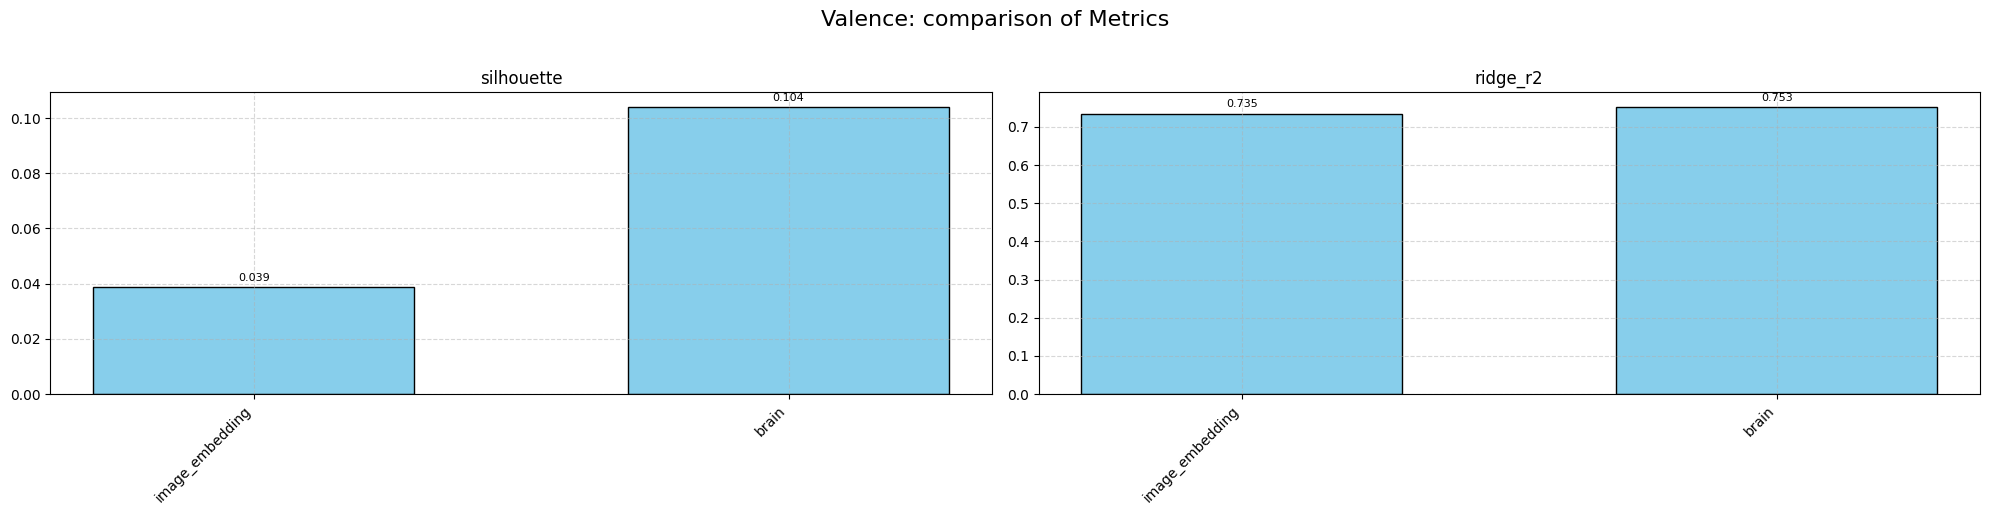

In [11]:
## Valence evaluation
res_lst = {}

res_image_embedding = evaluate_embedding(
    image_embedding,
    df_merged.Valence_mean.values,
    n_clusters=10,
)
res_lst["image_embedding"] = res_image_embedding

## Brain embedding
res_brain = evaluate_embedding(
    brain_embedding,
    df_merged.Valence_mean.values,
    n_clusters=10,
)
res_lst["brain"] = res_brain


# Data for each metric and each method
methods = ["image_embedding", "brain"]
metrics = {
    "silhouette": [x["silhouette"] for key, x in res_lst.items()],
    "ridge_r2": [x["ridge_r2"] for key, x in res_lst.items()],
}
plot_metrics(methods, metrics, "Valence")


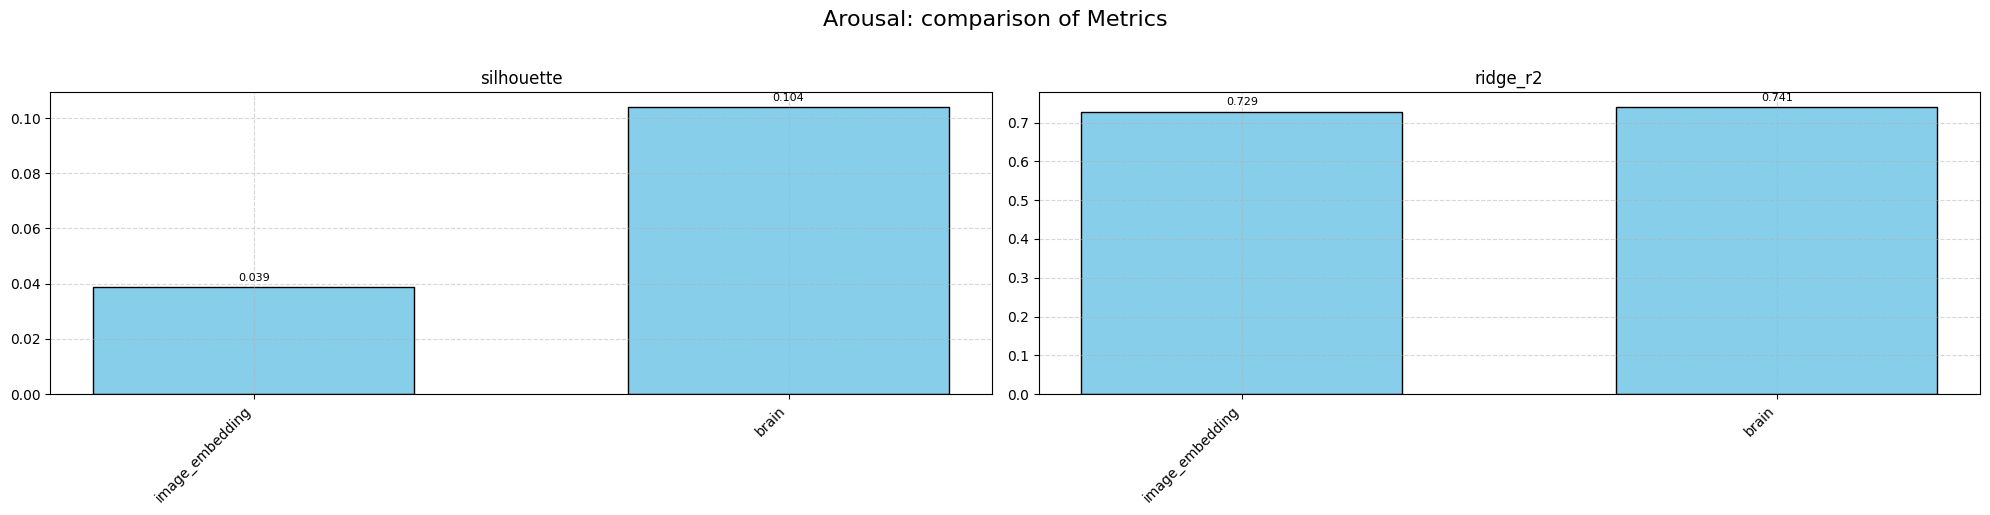

In [12]:
## Arousal evaluation
res_lst = {}

res_image_embedding = evaluate_embedding(
    image_embedding,
    df_merged.Arousal_mean.values,
    n_clusters=10,
)
res_lst["image_embedding"] = res_image_embedding

## Brain embedding
res_brain = evaluate_embedding(
    brain_embedding,
    df_merged.Arousal_mean.values,
    n_clusters=10,
)
res_lst["brain"] = res_brain


# Data for each metric and each method
methods = ["image_embedding", "brain"]
metrics = {
    "silhouette": [x["silhouette"] for key, x in res_lst.items()],
    "ridge_r2": [x["ridge_r2"] for key, x in res_lst.items()],
}
plot_metrics(methods, metrics, "Arousal")


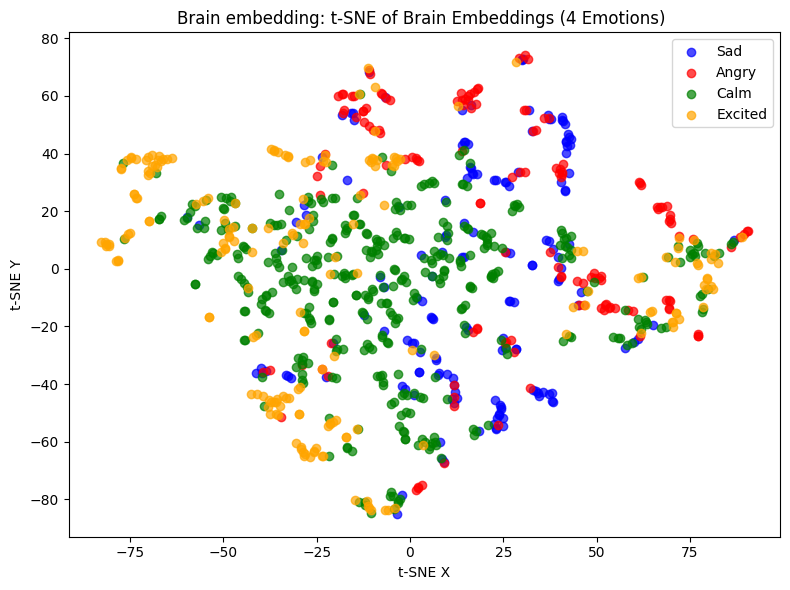

In [13]:

plot_emotion_tsne(X=brain_embedding,y_valence=valence_mean,y_arousal=arousal_mean, title="Brain embedding",perplex=5 if not do_openclip else 10)

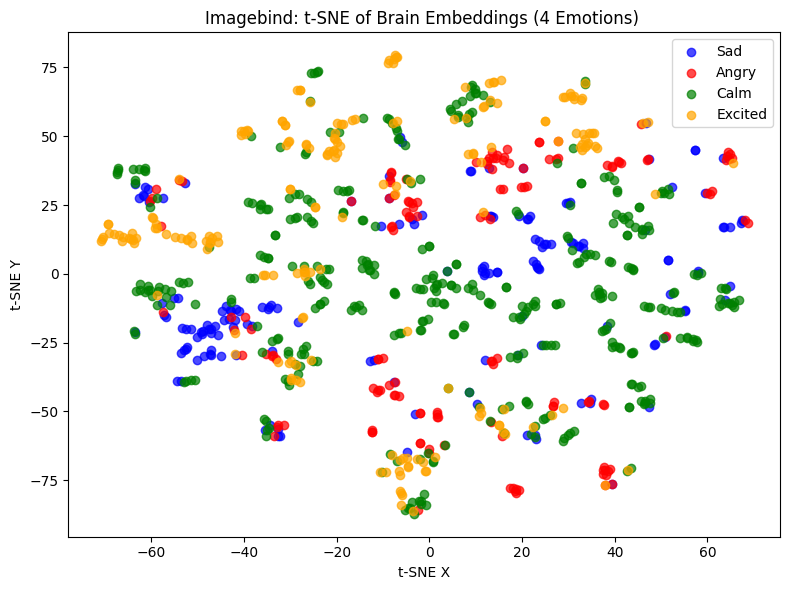

In [14]:
plot_emotion_tsne(X=image_embedding,y_valence=valence_mean,y_arousal=arousal_mean, title="Imagebind" if not do_openclip else "OpenCLIP",perplex = 5 if not do_openclip else 10)